# 8. 뉴스 요약 봇 만들기

# 데이터 가져오기

[News_Summary 사용하기](https://github.com/sunnysai12345/News_Summary)   

In [1]:
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)

,headlines,text
51428,What does US government shutdown mean?,A shutdown of US government services is trigge...
76268,US bombers conduct air drills near North Korea,US supersonic bombers and Japanese jets on Tue...
21751,Hotel asks Google engineer to leave after his ...,"The Caesars Palace hotel in the US, which host..."
96456,Indian-origin lady convicted over fake clothin...,The Birmingham Crown Court has convicted an In...
56959,Faulty parts caused fire in missing Argentinia...,Faulty parts may have caused a fire in the mis...
16404,"Nobody does it better, tweets user as Dhoni pl...",Reacting to ex-India captain MS Dhoni plotting...
45054,CPM claims BJP-IPFT coordinated attacks on Lef...,The CPM on Tuesday tweeted photos of violence ...
69709,Garbage arranged at India Gate for union minis...,Garbage was reportedly arranged by volunteers ...
44488,Alicia Vikander starrer 'Tomb Raider' hits the...,"Alicia Vikander starrer 'Tomb Raider', which r..."
78967,Gurugram engineering student jumps to death fr...,A 22-year-old engineering student allegedly co...


text와 headlines 두 가지 열로 구성되어 있다. 이들을 추상적 요약과 추출적 요약을 해보자. 
- 추상적 요약: 원문에서 새로운 문장을 생성해내는 방식이다.   
text를 본문, headlines를 요약된 데이터로 잡아서 모델을 학습해보자.
- 추출적 요약: 원문의 문장에서 핵심 문장을 추출해서 요약하는 방식이다.   
text를 사용해서 모델 학습해보자.

# 추상적 요약

# 데이터 전처리하기

### 데이터 정리하기

중복 샘플과 NULL 값을 제거해보자

In [3]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 텍스트 정규화와 불용어 제거하기

[정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)를 참고해서 텍스트 정규화를 진행해보자

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


nltk.corpus에서 import한 stopwords의 불용어를 참고해서 제거해보자.   
모든 영문을 소문자로 만들고 섞여있는 html 태그도 제거와 특수문자도 제거하자.   
그리고 이미 요약된 headlines는 자연스러운 문장을 결과값으로 받아야 하기 때문에 불용어 제거를 하지 않고 진행하자.

In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
clean_text = []
# 전체 text 데이터에 대한 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [12]:
print(len(clean_text))
print(len(clean_headlines))

98360
98360


텍스트 정제 후 빈 샘플이 있는지 확인한 후 Null값으로 바꾸고 제거해주자.

In [13]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
# Null값 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [15]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 훈련에 사용할 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


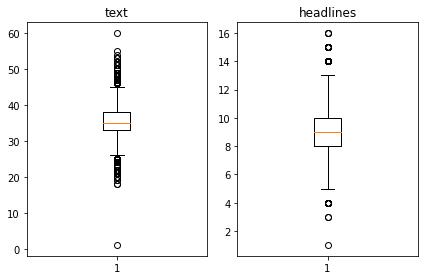

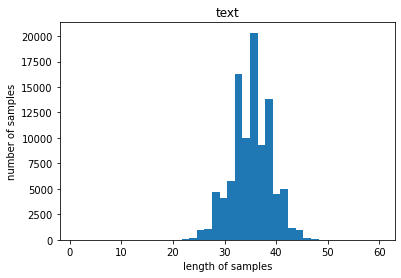

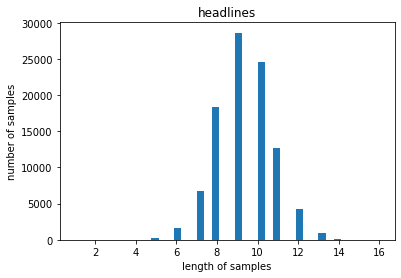

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위에 결과를 보고 적절한 최대 길이를 임의로 정해서 데이터의 몇 퍼센트를 자를지 확인해보자

In [17]:
text_max_len = 40
headlines_max_len = 11

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


퍼센트가 괜찮은거 같아 임의로 정한 길이보다 길면 제거하여 정제하자.

In [19]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


### 시작, 종료 토큰 추가하기

seq2seq 구조를 사용할건데 이는 시작토큰 SOS가 주어지면 종료토큰 EOS가 나올때까지 멈추지 않고 진행하므로 추가해주자.

In [20]:
# 요약 데이터 headlines에 시작 토큰과 종료 토큰 추가하기
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [21]:
# Numpy 타입으로 저장히기
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련 데이터와 테스트 데이터 분리하기

랜덤으로 번호를 만들고 이들을 데이터에 붙여 섞어주고 8:2 비율로 나누기

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[76510 29668 59462 ... 71343 36185 69089]


In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


In [25]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


### 정수 인코딩

라이브러리로 가져온 `Tokenizer()`를 이용해서 단어 토큰화하기. 먼저 원문인 text(encoder_input_train)를 진행해보자. 그리고 등장 빈도수가 낮은 데이터들을 확인해보자.

In [26]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
# print(src_tokenizer.word_index) 로 토큰화된 단어들을 볼 수 있다.

In [27]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64727
등장 빈도가 6번 이하인 희귀 단어의 수: 44133
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20594
단어 집합에서 희귀 단어의 비율: 68.18329290713304
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.779785251545193


위의 결과를 해석해보면 `encoder_input_train`에는 약 6만5천개의 단어들이 있고 등장이 6번 이하인 단어의 수가 약 4만4천개에 달한다. 그리고 68%의 데이터가 실제 훈련 데이터에서 등장 빈도는 3.8%밖에 되지 않으므로 정수 인코딩 과정에서 과감하게 제한하고 텍스트 데이터들을 정수로 변환해보자.

In [28]:
src_vocab = 20461
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1324, 14145, 1953, 13615, 402, 5960, 5960, 5960, 5960, 337, 1440, 1146, 147, 2411, 51, 1880, 3318, 4936, 520, 9193, 4747, 1367, 3251, 9399, 51, 3712, 17994, 760, 12685, 2932, 11883, 9193, 361, 187, 350], [561, 1111, 5240, 10, 230, 4019, 974, 171, 627, 289, 178, 12269, 260, 4611, 4653, 974, 664, 528, 2073, 13, 433, 260, 7398, 974, 171, 17995, 1885, 268, 47, 754, 561, 3173, 2559], [198, 147, 10, 530, 1419, 2086, 77, 770, 1214, 153, 4440, 598, 210, 86, 770, 2086, 1297, 530, 179, 2652, 3875, 1515, 4441, 373, 161, 210, 96, 700, 17030, 6831, 3638, 17996, 10074, 404, 770]]


동일하게 headlines 데이터 `decoder_input_train`에 적용하자.

In [30]:
tar_tokenizer = Tokenizer() # 토크나이저 정의
tar_tokenizer.fit_on_texts(decoder_input_train) # 입력된 데이터로부터 단어 집합 생성
# print(tar_tokenizer.word_index) 로 토큰화된 단어들을 볼 수 있다.

In [31]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28497
등장 빈도가 4번 이하인 희귀 단어의 수: 17640
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10857
단어 집합에서 희귀 단어의 비율: 61.90125276344879
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.361362652596642


In [32]:
tar_vocab = 10840
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2160, 9752, 1235, 379, 13, 1236, 2048, 6285, 53], [1, 250, 1125, 2161, 76, 40, 220, 905, 600], [1, 150, 1052, 3, 321, 8197, 4, 915], [1, 2049, 568, 4571, 106, 194, 7], [1, 7611, 3519, 344, 4572, 1027, 1443, 128]]
target
decoder  [[2160, 9752, 1235, 379, 13, 1236, 2048, 6285, 53, 2], [250, 1125, 2161, 76, 40, 220, 905, 600, 2], [150, 1052, 3, 321, 8197, 4, 915, 2], [2049, 568, 4571, 106, 194, 7, 2], [7611, 3519, 344, 4572, 1027, 1443, 128, 2]]


빈도수가 낮은 데이터로 구성된 빈 샘플들이 생겼을 가능성이 있으므로 확인해보자. 상대적으로 길이가 긴 text보다 짧은 headlines 데이터들이 그럴 가능성이 높다.   
또한 decoder_input과 decoder_target에는 토큰이 추가되었으므로 이들도 따로 체크해서 빈 샘플들이 있을 경우 삭제해주자.

In [33]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


### 패딩하기

In [34]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# 모델 설계하기

In [35]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

> WARNING이 나온다. 이는 recurrent dropout을 사용할때 cuDNN을 사용할 수 없어서 학습 시간이 오래 걸린다는 뜻이다.

LSTM은 dropout과 recurrent dropout을 사용한다. dropout은 과적합을 저지해주는 역할이고 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식으로 regularization와 과적합 저지 효과가 있다.

In [36]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) # initial_state에 hidden state, cell state값 넣어주기

In [37]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2619008     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 어텐션 메커니즘 사용하기

텐서플로우에 이미 구현된 Bahdanau 스타일 어텐션을 가져와서 적용해보자. [텐서플로우 bahdanau docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention)

In [38]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2619008     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# 모델 훈련하기

In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
269/269 [==============================] - 160s 564ms/step - loss: 6.1162 - val_loss: 5.6957
Epoch 2/50
269/269 [==============================] - 152s 566ms/step - loss: 5.5461 - val_loss: 5.3379
Epoch 3/50
269/269 [==============================] - 152s 564ms/step - loss: 5.2059 - val_loss: 5.0692
Epoch 4/50
269/269 [==============================] - 151s 561ms/step - loss: 4.9267 - val_loss: 4.8333
Epoch 5/50
269/269 [==============================] - 152s 566ms/step - loss: 4.7037 - val_loss: 4.6967
Epoch 6/50
269/269 [==============================] - 152s 565ms/step - loss: 4.5190 - val_loss: 4.5736
Epoch 7/50
269/269 [==============================] - 151s 561ms/step - loss: 4.3620 - val_loss: 4.4684
Epoch 8/50
269/269 [==============================] - 150s 556ms/step - loss: 4.2225 - val_loss: 4.3858
Epoch 9/50
269/269 [==============================] - 150s 558ms/step - loss: 4.0968 - val_loss: 4.3256
Epoch 10/50
269/269 [==============================] - 151s 563m

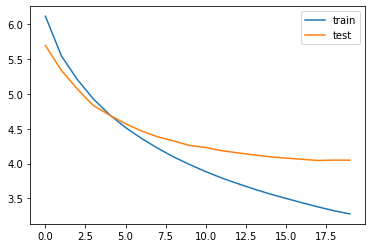

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 실제 결과와 요약문 비교하기

## 인퍼러스 모델 구현하기 
인퍼러스란 학습을 마친 모델로 실제 과제를 수행하는것을 말한다.   

seq2seq에 맞는 모델 설계를 진행하자.   
훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 넣고 디코더의 출력과 한번에 비교할 수 있으므로 이를 엮은 모델 하나만 준비했다. 하지만 정답 문장이 없는 인퍼러스 단계에서는 만든 문장의 길이만큼 코더가 반복 구조로 동작해주어야 한다.

In [41]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [42]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [43]:
# 출력층
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [44]:
# 인퍼러스 상태에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 모델 테스트하기
정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 하기위해 이를 하는 함수를 만들자. text의 정수 시퀀스에서 패딩을 위해 사용한 숫자 0을 제외하고, headlines의 정수 시퀀스는 숫자 0, 시작 종료 토큰을 제외하도록 만들자.

In [45]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [46]:
for i in range(90, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : talking wife mira rajput second pregnancy actor shahid kapoor said looking forward new member family feeling really good amazing feeling still time added shahid said second time feel new first time felt new 
실제 요약 : for new family member shahid on mira nd pregnancy 
예측 요약 :  am not to be karisma on rumoured boyfriend


원문 : actress aishwarya rai bachchan shared old pic late pm atal bihari vajpayee alongside caption respect rest peace late actress sridevi also seen picture actor anil kapoor although seen pictures shared aishwarya also present meet former pm 
실제 요약 : respect aishwarya shares old pic with late pm vajpayee 
예측 요약 :  aishwarya shares pic with late pm atal bihari vajpayee


원문 : ghaziabad municipal corporation sunday started work crore project aimed repairing restructuring nearly roads road patches surface completely top priority ghaziabad municipal commissioner cp singh said projects worth crore including construction roads boundary walls inaugurated 
실제 요약 : crore pro

# 추상적 요약 결과 살펴보기

문법 완성도 측면과 핵심 단어 포함 측면 그리고 내가 느꼈을때 요약이 제대로 되었는지으로 세가지 평가 항목으로 결과를 5개 정도 확인해보자.   

원문 : bjp ally national people party president friday said jd chief nitish kumar person could bjp power centre congress president rahul gandhi telling may nitish kumar prime minister mark words added   
실제 요약 : only nitish kumar can bjp at centre not rahul   
예측 요약 :  bjp alliance with alliance with bjp alliance with bjp alliance   
- 문법 완성도: X
- 핵심 단어 포함: X
- 내가 느낀 요약 결과: 1/5

원문 : congress mp chidambaram alleged government paying crore per rafale jet union minister smriti irani said use rafale issue political ends yeh public hai hai supreme court issued statement defence minister spoken cag access files added   
실제 요약 : yeh public hai hai smriti on chidambaram rafale charges   
예측 요약 :  truth is not political thing chidambaram on rafale scam   
- 문법 완성도: X
- 핵심 단어 포함: O(political가 들어갔음)
- 내가 느낀 요약 결과: 2/5

원문 : talking starting days car rental startup zoomcar co founder greg said day away shutting everything also said put savings zoomcar suddenly make break situation greg added startup faced initial lack trust local vendors   
실제 요약 : was day away from shutting everything zoomcar co founder   
예측 요약 :  startup co founder buys stake in electric startup   
- 문법 완성도: O
- 핵심 단어 포함: X(car rental, zoomcar)
- 내가 느낀 요약 결과: 1/5
예측이 어느정도 말은 맞는거 같은데 아예 다른 얘기가 나왔다.

원문 : north delhi municipal corporation listed public toilets one six zones google maps pilot project officials visited toilet complexes obtain exact uploaded information three days following implementation project karol bagh department list remaining zones google maps   
실제 요약 : public toilets in delhi listed on google maps   
예측 요약 :  delhi to launch its first ever train system   
- 문법 완성도: X
- 핵심 단어 포함: X
- 내가 느낀 요약 결과: 1/5

원문 : sheep world first mammal cloned adult cell die due early onset uk based study found researchers said wear tear joints similar naturally conceived sheep age result cloning perceived many   
실제 요약 : the sheep did not die early because of study   
예측 요약 :  scientists identify world largest human cells   
- 문법 완성도: O
- 핵심 단어 포함: X
- 내가 느낀 요약 결과: 1/5

__총 정리__   
문법 완성도 2/5, 핵심 단어 포함 1/5, 내가 느낀 결과: 1/5 4개, 2/5 1개   
처참한 결과가 나왔다. 성능을 개선하기 위해 seq2seq와 어텐선 조합 수정, 빔 서치, 사전 훈련된 워드 임베딩, 트랜스포머 등의 개선 방안들이 존재한다.

# 추출적 요약

## Summa를 이용하기

In [47]:
import requests
from summa.summarizer import summarize

In [48]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [49]:
data.sample(10)

,headlines,text
76109,"Insecurity, unease growing among Muslims in In...",A feeling of unease and insecurity is creeping...
41084,How are India's fuel prices compared to its ne...,Indians pay more for petrol and diesel compare...
35992,Pregnant Pakistani singer shot dead while perf...,A man shot dead pregnant Pakistani artist Sami...
34494,Why is Sachin's 143-run Sharjah knock called D...,"On April 22, 1998, Sachin Tendulkar scored 143..."
36911,Paw prints of pet dog help trace missing US to...,The paw prints of a pet dog helped a US family...
86256,"NIT Srinagar site hacked, hackers demand 'Free...",The website of National Institute of Technolog...
49224,Railways to create employee database to check ...,The Railway Board has passed a proposal to cre...
66426,E-commerce firms must settle seller payments i...,The Reserve Bank of India (RBI) has mandated e...
2119,BJP flies K'taka MLAs to Gurugram resort amid ...,Karnataka BJP has flown over 100 MLAs to a res...
95470,"Sachin, Sehwag tweet about India's 2011 World ...",India's 2011 World Cup-winning team members Sa...


data의 text를 이용해서 summarize 하고 나온 값을 headlines와 비교해보자.

In [50]:
data['text'].head()

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
Name: text, dtype: object

In [51]:
data['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

## summarize 사용하기

summarize()의 인자로 사용되는 값들을 알아보자
> text(str): 요약할 테스트   
ratio(float, optional): 요약문에서 원본으로 선택되는 문장 비율 0~1   
words(int or None, optional): 출력에 포함할 단어 수, 만약 ratio와 함께 두 파라미터가 모두 제공되면 ratio는 무시한다.   
split(bool, optional): True면 문장 list/False는 join된 문자열 반환한다   

summarize는 문장 토큰화를 별도로 진행하지 않아도 내부적으로 문장 토큰화를 수행한다.

In [52]:
i = 0
print('text: \n{}\n'.format(data['text'][i]))
print('headlines: \n{}\n'.format(data['headlines'][i]))
print('summarize: \n{}\n'.format(summarize(data['text'][i], ratio=0.5)))

text: 
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

headlines: 
upGrad learner switches to career in ML & Al with 90% salary hike

summarize: 
upGrad's Online Power Learning has powered 3 lakh+ careers.



꽤 괜찮게 나왔다. words를 조절해보자.

In [53]:
i = 0
print('text: \n{}\n'.format(data['text'][i]))
print('headlines: \n{}\n'.format(data['headlines'][i]))
print('summarize: \n{}\n'.format(summarize(data['text'][i], words=20)))

text: 
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

headlines: 
upGrad learner switches to career in ML & Al with 90% salary hike

summarize: 
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.



words를 작게하면 ratio를 조절한 결과값과 똑같이 나와서 키웠는데 너무 길어진다. 같이 사용하면 ratio로 결과값이 안나왔을 때 words가 대체해준다. 그래서 같이 사용한거로 5개 정도 분석해보자.

In [54]:
for i in range(55, 60):
    print('text: \n{}'.format(data['text'][i]))
    print('headlines: \n{}'.format(data['headlines'][i]))
    print('summarize: \n{}\n'.format(summarize(data['text'][i], ratio=0.5, words=20)))

text: 
Actress Mishti, who has featured in 'Manikarnika: The Queen of Jhansi', has said the film's co-director Kangana Ranaut made false promises to the cast. "Kangana had said, 'I want dates because all characters look jumbled up...I'm trying my best to give everybody a prominent space on screen.' After watching the movie, there is no scope for other characters," Mishti added. 
headlines: 
Kangana made fake promises to cast: 'Manikarnika' actress Mishti
summarize: 
Actress Mishti, who has featured in 'Manikarnika: The Queen of Jhansi', has said the film's co-director Kangana Ranaut made false promises to the cast.

text: 
The high-powered committee led by PM Narendra Modi to select the next CBI Director will meet again on February 1, Congress leader Mallikarjun Kharge has said. The panel consisting of Kharge and Chief Justice of India Ranjan Gogoi met on January 24, but the meeting ended "inconclusively" after Kharge cited lack of details in the list of 80 IPS officers. 
headlines: 
P

# 추출적 요약 분석 

추상적 요약과 동일하게 문법 완성도 측면과 핵심 단어 포함 측면 그리고 내가 느꼈을때 요약이 제대로 되었는지으로 세가지 평가 항목으로 5개의 결과를 확인해보자.   

text: 
Actress Mishti, who has featured in 'Manikarnika: The Queen of Jhansi', has said the film's co-director Kangana Ranaut made false promises to the cast. "Kangana had said, 'I want dates because all characters look jumbled up...I'm trying my best to give everybody a prominent space on screen.' After watching the movie, there is no scope for other characters," Mishti added.   
headlines: 
Kangana made fake promises to cast: 'Manikarnika' actress Mishti   
summarize: 
Actress Mishti, who has featured in 'Manikarnika: The Queen of Jhansi', has said the film's co-director Kangana Ranaut made false promises to the cast.   
- 문법 완성도: X
- 핵심 단어 포함: O
- 내가 느낀 요약 결과: 3/5
요약된 결과의 맨 앞 문장이 없었으면 깔끔해보였을거같은데 아쉽다. text 문단의 앞 문장을 그대로 가져온것이지만 뒷부분의 부가설명이 없으니 이상해보인다.

text: 
The high-powered committee led by PM Narendra Modi to select the next CBI Director will meet again on February 1, Congress leader Mallikarjun Kharge has said. The panel consisting of Kharge and Chief Justice of India Ranjan Gogoi met on January 24, but the meeting ended "inconclusively" after Kharge cited lack of details in the list of 80 IPS officers.   
headlines: 
PM-led panel to meet on Friday to pick new CBI chief: Kharge   
summarize: 
The high-powered committee led by PM Narendra Modi to select the next CBI Director will meet again on February 1, Congress leader Mallikarjun Kharge has said.   
- 문법 완성도: O
- 핵심 단어 포함: O
- 내가 느낀 요약 결과: 4/5
해드라인과 내용이 전혀 다르지만 꽤 괜찮아보인다.

text: 
Nevada State Athletic Commission has banned MMA fighters Conor McGregor and Khabib Nurmagomedov for six months and nine months respectively over their roles in the mass brawl that occurred after their fight at UFC 229 last October. McGregor and Khabib have been fined $50,000 (Ã¢ÂÂ¹35 lakh) and $500,000 (Ã¢ÂÂ¹3.5 crore) respectively. The brawl occurred after Nurmagomedov confronted McGregor's teammate.   
headlines: 
McGregor fined Ã¢ÂÂ¹35 lakh, Khabib Ã¢ÂÂ¹3.5 crore for brawl; both banned   
summarize: 
Nevada State Athletic Commission has banned MMA fighters Conor McGregor and Khabib Nurmagomedov for six months and nine months respectively over their roles in the mass brawl that occurred after their fight at UFC 229 last October.   
- 문법 완성도: O
- 핵심 단어 포함: O
- 내가 느낀 요약 결과: 3/5
요약이라기엔 많이 아쉬운 문장이다.

text: 
Pakistan captain Sarfaraz Ahmed, who has been banned for four matches over racist remarks, took an apparent dig at his critics by sharing a video of a child reciting 'log hai na' poem on Twitter. "Pyaar karna hai to khud se kar...dushmani karne ke liye log hai na," the poem read. "This is how the world is," Sarfaraz wrote.   
headlines: 
Banned for 4 matches, Sarfaraz shares 'log hai na' poem for critics   
summarize: 
Pakistan captain Sarfaraz Ahmed, who has been banned for four matches over racist remarks, took an apparent dig at his critics by sharing a video of a child reciting 'log hai na' poem on Twitter.   
- 문법 완성도: O
- 핵심 단어 포함: O
- 내가 느낀 요약 결과: 4/5 
꽤 괜찮게 나왔다.

text: 
Banned cricketer Sreesanth has told Supreme Court he initially confessed to Delhi Police about his alleged involvement in 2013 IPL spot-fixing scandal to escape continuous police torture. Sreesanth further said the bookie tried dragging him into spot-fixing but he didn't fall for it. Citing Sreesanth not informing BCCI about fixing approach, the apex court said Sreesanth's conduct "wasn't good".   
headlines: 
Confessed to spot-fixing to escape police torture: Sreesanth to SC   
summarize: 
Sreesanth further said the bookie tried dragging him into spot-fixing but he didn't fall for it.   
- 문법 완성도: O
- 핵심 단어 포함: X
- 내가 느낀 요약 결과: 1/5

__총 정리__   
문법 완성도 4/5, 핵심 단어 포함 4/5, 내가 느낀 결과: 1/5 1개, 3/5 2개, 4/5 2개   
추상적 요약과 비교하면 훨씬 좋은 결과가 나왔다.

# 회고

결과를 확인할 때 구글 번역기와 파파고를 돌려서 제대로 된 결과를 확인한건지 아직도 찜찜하다. 그래도 총 정리를 다시 보자면   
__추상적 요약__   
문법 완성도 2/5, 핵심 단어 포함 1/5, 내가 느낀 결과: 1/5 4개, 2/5 1개   
__추출적 요약__   
문법 완성도 4/5, 핵심 단어 포함 4/5, 내가 느낀 결과: 1/5 1개, 3/5 2개, 4/5 2개   

성능이 애매한 모델로 추상적 요약하기보다 추출적으로 요약하는게 결과물이 훨씬 좋게 나왔다.   

정수 인코딩 하는 과정에서 LMS는 희귀 단어를 제외한 단어들의 집합이 8238 이렇게 나왔는데 갑자기 8000으로 뚝 잘라서 계산을 했다. 이 부분에 중요한 단어들이 잘렸으면 어떡하지? 라는 의문점이 생겨 나는 진행할 때 나온 그대로 넣어서 인코딩을 진행했다.   
과거 익스 진행하면서 RNN의 뒤로 갈수록 중요해지는 특성때문에 pre로 넣어 문장 앞에 더미 데이터를 넣는게 좋다고 들었다. 하지만 이번에는 max_len까지 패딩하는 과정에서 post로 넣어줬는데, pre로 바꿔주면 결과가 많이 달랐을까? 이러한 과정이 seq2seq나 어텐션 메커니즘과의 상관관계도 궁금하다.   

결과물이 만족스럽지 않아서 아쉬움이 많이 남는 익스였다. 그리고 여전히 NLP하는 과정은 익숙하지 않다. 계속해서 작업 노트북의 길이가 길어지고 있는데 전에 선언했던 함수를 다시 쓰려니 복잡하고 헷갈리기 시작했다. 규모가 커질수록 함수와 변수가 엄청 많이 선언될탠데 현업에 종사하시는 분들은 어떤식으로 관리할까? 그리고 변수와 함수명을 어떻게 선언해야 효율적인지 모르겠다. [변수명을 잘 짓기 위한 몸부림 블로그](https://brunch.co.kr/@wapj2000/29) 블로그를 확인해보니 IDE 사용과 변수명 선언 관련 룰을 정했는데 사람마다 다 다르게 정의하고 있어서 어지럽지만 도움이 될거같다.